In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("./survey_norm.csv")

In [2]:
from ast import literal_eval
dataset= []
for i in range(data['input_data'].size):
    dataset.append([np.array(literal_eval(data['input_data'][i].replace(' ', ',').replace(',,', ',')), dtype = float)
                     , int(data['exp_data'][i])])

In [3]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [4]:
import random
random.shuffle(dataset)

In [6]:
train_set = dataset[:-30]
test_set = dataset[-30:]

train_input = []
train_target = []

test_input = []
test_target = []
for i in range(len(train_set)):
    train_input.append(train_set[i][0].copy())
    train_target.append(train_set[i][1])

train_input = np.array(train_input)
train_target = np.array(train_target)

for i in range(len(test_set)):
    test_input.append(test_set[i][0].copy())
    test_target.append(test_set[i][1])

test_input = np.array(test_input)
test_target = np.array(test_target)

In [18]:
train_a = 0
train_b = 0

for data in train_set:
    if data[1] == 0:
        train_a += 1
    else :
        train_b += 1
print(train_a, train_b)

54 65


In [59]:
import tensorflow as tf
from keras import models 
from keras import layers
from keras import regularizers

def build_model(train_len):
    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'relu', input_shape = (train_len, )))
    model.add(layers.Dense(8, activation = 'relu'))
    #model.add(layers.Dense(4, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), 'accuracy'])
    #model.compile(optimizer = 'adam', loss='mse', metrics=['accuracy'])
    return model


In [60]:
k = 4
num_val_sample = len(train_input) // k
num_epochs = 200
all_mae_histories = []

np.random.shuffle(train_input)
for i in range(k):
    val_input = train_input[i * num_val_sample : (i+1) * num_val_sample]
    val_target = train_target[i * num_val_sample : (i+1) * num_val_sample]
    
    partial_train_input = np.concatenate(
        [train_input[:i * num_val_sample],
         train_input[(i + 1) * num_val_sample:]], axis = 0)
    partial_train_target = np.concatenate(
        [train_target[:i * num_val_sample],
         train_target[(i + 1) * num_val_sample:]], axis = 0)
    
    model = build_model(partial_train_input.shape[1])
    history = model.fit(partial_train_input, partial_train_target, 
                        validation_data = (val_input, val_target), epochs = num_epochs, 
              batch_size = 4, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [61]:
average_mae_history = [np.mean([x[i] for  x in all_mae_histories]) for i in range(num_epochs)]

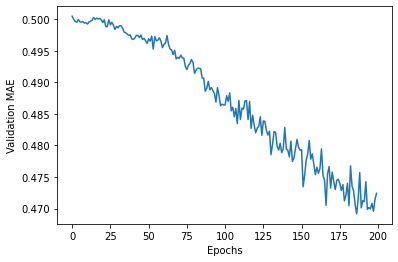

In [62]:
import matplotlib.pyplot as plt

#smooth_mae_history = smooth_curve(average_mae_history[10:])

#plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

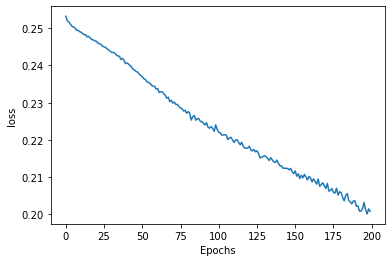

In [63]:
history_dict = history.history

plt.plot(range(num_epochs), history_dict['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [64]:
model = build_model(train_input.shape[1])
model.fit(train_input, train_target, epochs = 100, batch_size = 4, verbose = 0)
test_mse, test_mae, test_acc = model.evaluate(test_input, test_target)
print(test_mse, test_mae)

1/1 [==============================] - 0s 68ms/step - loss: 0.2673 - mean_absolute_error: 0.4968 - accuracy: 0.6333
0.2672734260559082 0.4967743158340454


In [65]:
pred_result = model.predict(test_input)
out = []
for data in pred_result:
    if data > 0.5:
        out.append(1)
    else:
        out.append(0)
pred_result

array([[0.6396357 ],
       [0.70350456],
       [0.5014572 ],
       [0.6722695 ],
       [0.60031295],
       [0.25937456],
       [0.38277844],
       [0.6611352 ],
       [0.44539085],
       [0.45309612],
       [0.46587777],
       [0.6549274 ],
       [0.37877607],
       [0.5455249 ],
       [0.5854351 ],
       [0.4961442 ],
       [0.76511973],
       [0.61147636],
       [0.6737675 ],
       [0.62435466],
       [0.6890083 ],
       [0.6479988 ],
       [0.5557134 ],
       [0.67544293],
       [0.56835085],
       [0.7284708 ],
       [0.62582934],
       [0.67912793],
       [0.53807056],
       [0.6901496 ]], dtype=float32)

In [66]:
for i in range(pred_result.shape[0]):
    print(test_input[i], ', ', test_target[i], ', ', out[i] )

[1.  0.6 0.8 0.2 0.8 0.4 1.  0. ] ,  1 ,  1
[0.8 0.4 0.4 0.4 0.8 0.4 0.6 1. ] ,  1 ,  1
[1.  1.  0.6 0.4 0.8 1.  1.  1. ] ,  1 ,  1
[0.8 0.8 0.8 0.8 0.6 0.6 0.8 0. ] ,  1 ,  1
[1.  0.8 0.2 0.8 0.4 0.6 0.4 0. ] ,  1 ,  1
[0.6 1.  0.8 1.  0.4 0.6 0.8 1. ] ,  1 ,  0
[0.6 0.8 0.6 0.6 0.4 0.6 0.6 1. ] ,  1 ,  0
[1.  0.8 0.4 0.8 0.4 0.4 0.6 0. ] ,  1 ,  1
[1.  0.8 0.4 0.4 0.6 0.8 0.8 1. ] ,  1 ,  0
[0.8 1.  0.8 0.8 0.4 0.4 0.8 1. ] ,  0 ,  0
[1.  0.6 0.2 1.  0.4 0.2 0.2 1. ] ,  0 ,  0
[0.8 1.  0.6 0.6 0.4 0.4 0.8 0. ] ,  1 ,  1
[1.  0.8 0.4 1.  0.4 0.2 0.4 1. ] ,  1 ,  0
[1.  1.  0.4 0.2 0.6 0.6 0.8 1. ] ,  1 ,  1
[1.  1.  0.6 0.8 0.8 0.6 0.4 1. ] ,  1 ,  1
[0.8 1.  0.4 0.4 0.6 0.4 0.6 1. ] ,  0 ,  0
[1.  1.  0.8 0.4 0.8 0.6 0.6 1. ] ,  0 ,  1
[0.8 0.4 0.4 0.8 0.8 0.6 0.6 0. ] ,  1 ,  1
[1.  0.8 0.8 0.6 0.4 0.4 0.6 1. ] ,  0 ,  1
[1.  0.8 1.  1.  0.6 0.6 0.6 1. ] ,  1 ,  1
[1.  0.8 0.6 0.4 0.6 0.4 0.4 0. ] ,  1 ,  1
[0.8 0.8 0.8 0.6 0.6 0.6 0.8 0. ] ,  0 ,  1
[0.4 1.  1.  0.6 0.6 0.6 1.  1. 

In [ ]:
for i in range(train_input.shape[0]):
    print(train_input[i], train_target[i])

In [ ]:
model.summary()

In [ ]:
model.save('TT_datamodel')

In [ ]:
from keras import models
new_model = models.load_model('TT_datamodel')
new_model.evaluate(test_input, test_target)